# EmoNet

Built by ***Jialiang Zhao***

Most data is labelled by ***Jiawei Zhang***

Other data contributors: (From EmoWeb)

***Jiawen Wu, Chenyang Ling, Hao Lu, Jialiang Zhao, (don't know your name)***

----------------------

#### Platform: 
Python 3.6, Google Tensorflow 1.1, Numpy, Jupyter

#### Inspired By:

Beijing Institute of Technology, *Pattern Recognition* by ***Prof. Qi Gao***

Stanford, CS231n *Convolutional Neural Networks in Visual Recognition* by ***Prof. Fei Fei Li***

#### Network Structure:

| Layer Name | Input Size | Output Size | Comment|
| ------ | ------ | ------ | ------ |
|**Input**| 144 x 3| - | - |
|**Augmentation (Affine)**| 144 x 3 | 32 x 32 x 3 | vectorized and augmented|
|**ConvLayer32**| 32 x 32 x 3 | 28 x 28 x 32 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 28 x 28 x 32 | 28 x 28 x 32 | - |
|**ConvLayer64 1**| 28 x 28 x 32 | 24 x 24 x 64 | Nonlinear Activation: RELU |
|**ConvLayer64 2**| 24 x 24 x 64 | 20 x 20 x 64 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 20 x 20 x 64 | 20 x 20 x 64 | - |
|**ConvLayer128**| 20 x 20 x 64 | 16 x 16 x 128 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 16 x 16 x 128 | 16 x 16 x 128 | - |
|**ConvLayer256**| 16 x 16 x 128 | 12 x 12 x 256 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 12 x 12 x 256 | 6 x 6 x 256 | reduced pooling, for efficiency in FCNN |
|**Affine**| 6 x 6 x 256 = 9216 | 1024 | Nonlinear Activation: RELU | 
|**Dropout**| - | - | reduce overfitting | 
|**Affine**| 1024 | 1024 | Nonlinear Activation: RELU | 
|**Dropout**| - | - | reduce overfitting | 
|**Output Affine**| 1024 | 5 | - |

#### Total Trainable Parameters: 
150 MB *(float32)*

#### Training Cost: 
About ***30 hr*** CPU (aborted) and ***4 hr*** GPU

#### Runtime Cost: 
***5.44 ms +- 103 us*** With GPU (NV Quadro M2000M, 4GB)

***20.32 ms +- 96 us*** With CPU (Intel Xeon v5 1505M, 2 of 4 cores used)


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

from tools import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Restoring parameters from checkpoints/checkpoint.data


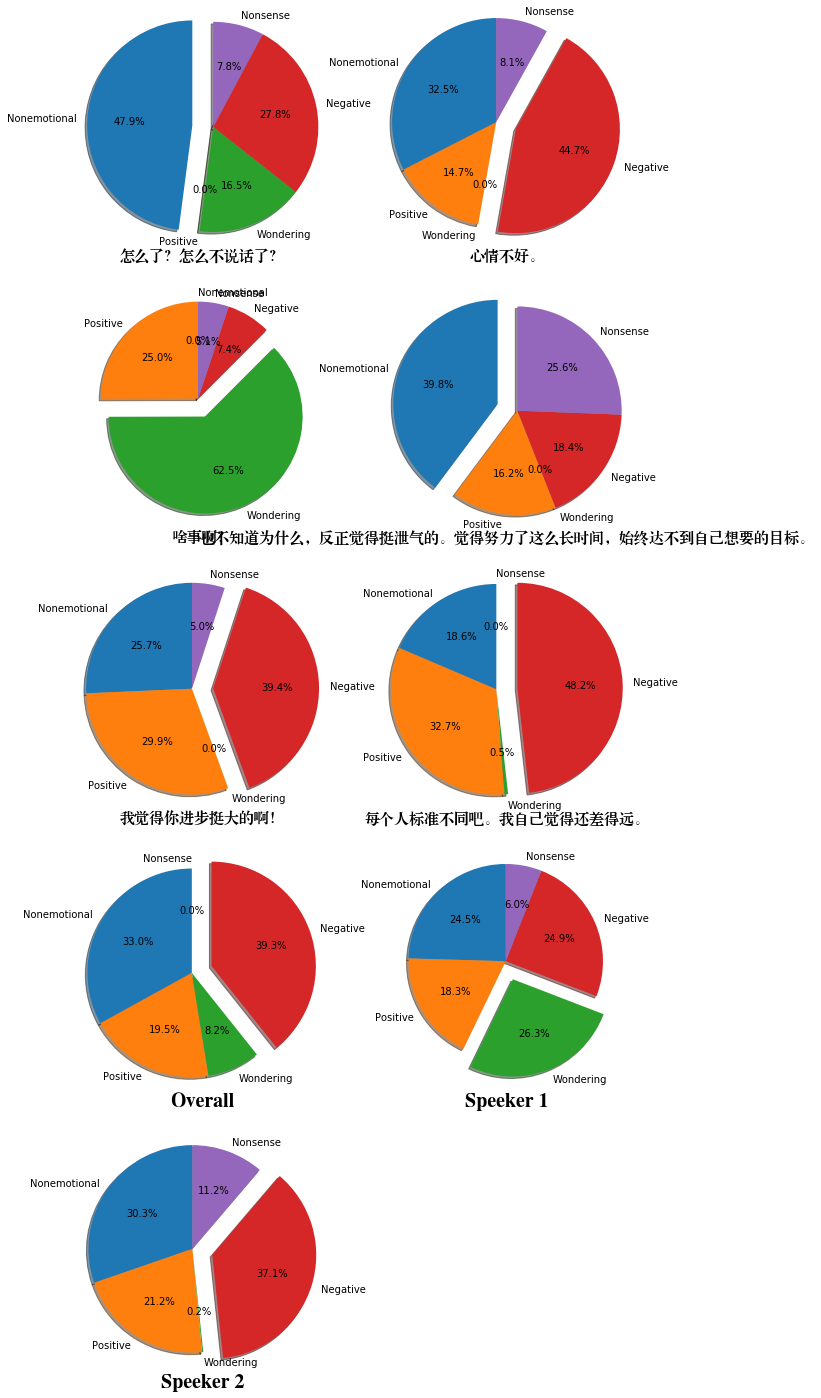

In [9]:


import re
filename = 'testfile.txt'
testFile = open(filename, 'rb')
reWord = re.compile(u'(?<=\uff1a).+')
lines = testFile.readlines()
tests = []
for line in lines:
    if len(reWord.findall(line.decode('utf8')))>0:
        tests.append(reWord.findall(line.decode('utf8'))[0])

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 144, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# For dropout
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)

x_before = []
for test in tests:
    x_line = []
    for c in test.encode('utf-8'):
        x_line.append(int(c))
    x_before.append(x_line)

x = np.zeros([len(x_before), 144, 3], dtype = float)

for cnt in range(len(x_before)):
    data_cur = x_before[cnt]
    xe = np.zeros([3*144], dtype=float)
    tmp = 0
    for i in data_cur:
        xe[tmp] = i
        tmp += 1
        if tmp >= 144*3: break
    xe.reshape((3,144))
    x[cnt] = xe.reshape(144,3).copy()


y_out = EmoNet(X,y,keep_prob1,keep_prob2,is_training)

from matplotlib import font_manager
ans = np.asarray([0])
with tf.Session() as sess:
    saver = tf.train.Saver()
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()
        
        #saver.restore(sess, "checkpoints/checkpoint.data")
        saver.restore(sess, "checkpoints/checkpoint.data")
        
        ans = sess.run(y_out,feed_dict={X:x,keep_prob1:1.0,keep_prob2:1.0,is_training:False})
        #timeit sess.run(y_out,feed_dict={X:x,keep_prob1:drop1,keep_prob2:drop2,is_training:True})
        #print(ans)
        datanum = ans.shape[0] + 3 # for overall
        if datanum%2 == 1: datanum += 1
        tmp = 0
        labels = 'Nonemotional', 'Positive', 'Wondering', 'Negative', 'Nonsense'
        myfont=font_manager.FontProperties(fname='song.ttf')
        fig1, ax1 = plt.subplots(ncols=2,nrows=int(datanum/2), figsize=(2*5, 5*datanum/2))
        for i in ans:
            tmp += 1
            i -= np.amin(i)
            i *= 100.0/np.sum(i)
            explode = np.array([0,0,0,0,0], dtype=float)
            explode[np.argmax(i)] = 0.2
            sizes = i.tolist()
            plt.subplot(datanum/2, 2, tmp)
            plt.pie(sizes, labels=labels, explode = explode.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
            plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            plt.xlabel(tests[tmp-1],fontproperties=myfont,fontsize=15)  
        
        overall = np.mean(ans, axis = 0)
        overall -= np.amin(overall)
        overall *= 100.0/np.sum(overall)
        explode = np.array([0,0,0,0,0], dtype=float)
        explode[np.argmax(overall)] = 0.2
        sizes = overall.tolist()
        plt.subplot(datanum/2, 2, tmp+1)
        plt.pie(sizes, labels=labels, explode = explode.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.xlabel('Overall',fontproperties=myfont,fontsize=20)
        
        A=ans[np.arange(0,ans.shape[0],2)]
        B=ans[np.arange(1,ans.shape[0],2)]
        overall = np.mean(A, axis = 0)
        explode = np.array([0,0,0,0,0], dtype=float)
        explode[np.argmax(overall)] = 0.2
        sizes = overall.tolist()
        plt.subplot(datanum/2, 2, tmp+2)
        plt.pie(sizes, labels=labels, explode = explode.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.xlabel('Speeker 1',fontproperties=myfont,fontsize=20)
        
        overall = np.mean(B, axis = 0)
        explode = np.array([0,0,0,0,0], dtype=float)
        explode[np.argmax(overall)] = 0.2
        sizes = overall.tolist()
        plt.subplot(datanum/2, 2, tmp+3)
        plt.pie(sizes, labels=labels, explode = explode.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.xlabel('Speeker 2',fontproperties=myfont,fontsize=20)
        
        if (ans.shape[0] + 1)%2:
            plt.subplot(datanum/2, 2, tmp+4)
            plt.axis('off')
        plt.show()